## Урок 3. Домашнее задание

## Практическое задание

  1. Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора)  на датасет from sklearn.datasets import load_boston. 
  2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

  3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

  1-2. (*)  Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews .Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    
    
</ol>

## Предобработка данных

In [113]:
!pip install tensorflow_addons

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow_datasets.text import IMDBReviews

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(tf.__version__)

2.7.0


Загрузим датасет с ценами на жилье в Бостоне и сразу разобьем его на обучающую и тестовую выборки:

In [115]:
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=42)

train_df = pd.DataFrame(X_train, columns=load_boston().feature_names)
test_df = pd.DataFrame(X_test, columns=load_boston().feature_names)

Посмотрим на типы и основные статистики признаков в изучаемом датасете:

In [116]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     354 non-null    float64
 1   ZN       354 non-null    float64
 2   INDUS    354 non-null    float64
 3   CHAS     354 non-null    float64
 4   NOX      354 non-null    float64
 5   RM       354 non-null    float64
 6   AGE      354 non-null    float64
 7   DIS      354 non-null    float64
 8   RAD      354 non-null    float64
 9   TAX      354 non-null    float64
 10  PTRATIO  354 non-null    float64
 11  B        354 non-null    float64
 12  LSTAT    354 non-null    float64
dtypes: float64(13)
memory usage: 36.1 KB


In [117]:
train_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,3.469887,11.403955,11.133051,0.073446,0.557259,6.325672,68.799718,3.765874,9.437853,407.042373,18.277966,359.701808,12.421130
std,8.315831,22.608457,6.938651,0.261237,0.116792,0.719211,27.665360,2.126032,8.639971,166.522237,2.256792,86.924779,7.112402
min,0.009060,0.000000,1.210000,0.000000,0.385000,3.863000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082320,0.000000,5.130000,0.000000,0.450000,5.889500,46.025000,2.073700,4.000000,279.000000,16.650000,376.782500,6.862500
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.227500,77.350000,3.107300,5.000000,330.000000,18.600000,391.600000,10.925000
75%,3.281688,20.000000,18.100000,0.000000,0.631000,6.681750,93.475000,5.400700,24.000000,666.000000,20.200000,396.172500,16.225000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Видим, что все признаки вещественные, однако имеют разную размерность, что может создать проблемы при осуществлении процедуры градиентного спуска, поэтому нормализуем данные. Кроме того заметим, что признак `CHAS` принимает всего два значения и к нему можно не применять нормализацию.

In [118]:
train_df['CHAS'].value_counts()

0.0    328
1.0     26
Name: CHAS, dtype: int64

In [119]:
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [120]:
cont_transformers = []
cont_columns = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']

cat_transformers = []
cat_columns = ['CHAS']

for col in cont_columns:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=col)),
                ('standard', StandardScaler())
            ])
    cont_transformers.append((col, transfomer))

for col in cat_columns:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=col)),
            ])
    cat_transformers.append((col, transfomer))

feats = FeatureUnion(cont_transformers+cat_transformers)

In [121]:
X_train = feats.fit_transform(train_df)
X_test = feats.transform(test_df)

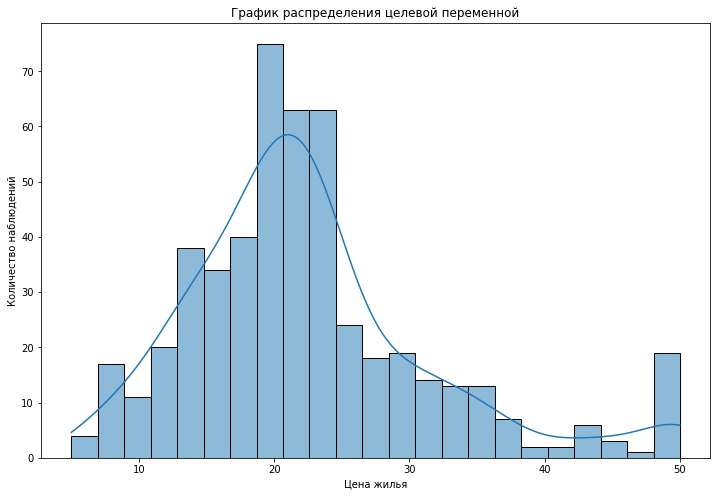

In [122]:
plt.figure(figsize=(12, 8))
sns.histplot(y, stat='count', kde=True)

plt.xlabel('Цена жилья')
plt.ylabel('Количество наблюдений')
plt.title('График распределения целевой переменной')
plt.show()

Заметен выброс в правой части распределения, который заметно утяжеляет хвост распределения.

## Построение модели

В качестве baseline построим сеть с двумя внутренними слоями и линейной активацией.

In [123]:
model = Sequential([
                    Dense(32, activation='linear', input_shape=(13,)),
                    Dense(16, activation='linear'),
                    Dense(1, activation='linear')
                    ])

model.summary()

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_570 (Dense)           (None, 32)                448       
                                                                 
 dense_571 (Dense)           (None, 16)                528       
                                                                 
 dense_572 (Dense)           (None, 1)                 17        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


С учетом условий задачи по моему мнению можно использовать среднеквадратическую ошибку как лосс и $R^{2}$ как метрику для оценки качества модели. Скомпилируем модель:

In [124]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))

Оценим качество модель:

In [125]:
# if tf.config.experimental.list_physical_devices("GPU"):
#   with tf.device("GPU:0"): 
h = model.fit(X_train, y_train, epochs=30, validation_split=0.15, verbose=0)
test_loss, test_r2 = model.evaluate(X_test, y_test, verbose=0)
print(f'R2 на трейне - {h.history.get("r_square")[-1]:.6f};\n'
      f'R2 на валидационном сете - {h.history.get("val_r_square")[-1]:.6f};\n'
      f'R2 на тесте - {test_r2:6f}.')
    

R2 на трейне - 0.707494;
R2 на валидационном сете - 0.633002;
R2 на тесте - 0.625897.


Как видим модель получилась весьма посредственная, попробуем улучшить ее. Для начала попробуем изменить количество нейронов в слоях и количество эпох:

In [126]:
def eval_model(X_train, y_train, epoch, val_split=0.15):
  # if tf.config.experimental.list_physical_devices("GPU"):
      # with tf.device("GPU:0"): 
        h = model.fit(X_train, y_train, epochs=epoch, validation_split=0.15, verbose=0)
        test_loss, test_r2 = model.evaluate(X_test, y_test, verbose=0)
        print(f'\tR2 на трейне - {h.history.get("r_square")[-1]:.6f};\n'
              f'\tR2 на валидационном сете - {h.history.get("val_r_square")[-1]:.6f};\n'
              f'\tR2 на тесте - {test_r2:6f}.')

In [127]:
neurons  = [64, 128, 256, 512]
epochs = [30, 50, 100, 200]

for neuron in neurons:
  for epoch in epochs:
    model = Sequential([Dense(neuron, activation='linear', input_shape=(13,)),
                        Dense(int(neuron/2), activation='linear'),
                        Dense(1, activation='linear')])
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))
    
    print(f'Количество нейронов в первом внутреннем слое - {neuron}, '
          f'Количество эпох - {epoch}:')

    eval_model(X_train, y_train, epoch)

Количество нейронов в первом внутреннем слое - 64, Количество эпох - 30:
	R2 на трейне - 0.749169;
	R2 на валидационном сете - 0.554660;
	R2 на тесте - 0.626339.
Количество нейронов в первом внутреннем слое - 64, Количество эпох - 50:
	R2 на трейне - 0.744270;
	R2 на валидационном сете - 0.562798;
	R2 на тесте - 0.682701.
Количество нейронов в первом внутреннем слое - 64, Количество эпох - 100:
	R2 на трейне - 0.751625;
	R2 на валидационном сете - 0.592616;
	R2 на тесте - 0.706971.
Количество нейронов в первом внутреннем слое - 64, Количество эпох - 200:
	R2 на трейне - 0.745560;
	R2 на валидационном сете - 0.533622;
	R2 на тесте - 0.657392.
Количество нейронов в первом внутреннем слое - 128, Количество эпох - 30:
	R2 на трейне - 0.748083;
	R2 на валидационном сете - 0.457131;
	R2 на тесте - 0.559876.
Количество нейронов в первом внутреннем слое - 128, Количество эпох - 50:
	R2 на трейне - 0.733969;
	R2 на валидационном сете - 0.536154;
	R2 на тесте - 0.663751.
Количество нейронов в пе

При перезапуске метрики сильно меняются, поэтому сложно выбрать оптимальную модель из предыдущих. Одновременно это вероятно дополнительно указывает на низкое качество построенных моделей. Посмотрим, как изменяются результаты модели при использовании разных оптимизаторов:

In [128]:
for optim in ['SGD', 'RMSProp','adam','NAdam']:
    model = Sequential([Dense(256, activation='linear', input_shape=(13,)),
                        Dense(128, activation='linear'),
                        Dense(1, activation='linear')])
    
    model.compile(optimizer=optim,
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))

    print(f'Оптимайзер {optim}:')

    eval_model(X_train, y_train, epoch=100)

Оптимайзер SGD:
	R2 на трейне - nan;
	R2 на валидационном сете - nan;
	R2 на тесте -    nan.
Оптимайзер RMSProp:
	R2 на трейне - 0.737452;
	R2 на валидационном сете - 0.572564;
	R2 на тесте - 0.695854.
Оптимайзер adam:
	R2 на трейне - 0.749932;
	R2 на валидационном сете - 0.585743;
	R2 на тесте - 0.707165.
Оптимайзер NAdam:
	R2 на трейне - 0.749004;
	R2 на валидационном сете - 0.587225;
	R2 на тесте - 0.709734.


Результаты для разных оптимайзеров получились схожие, при этом для `SGD` судя по всему модель построить не удалось. Попробуем использовать другую функцию активации и уменьшить скорость обучения:

In [129]:
tf.random.set_seed(42)

lr = 1e-3

for optim in [tf.keras.optimizers.SGD(learning_rate=lr),
              tf.keras.optimizers.RMSprop(learning_rate=lr),
              tf.keras.optimizers.Adam(learning_rate=lr),
              tf.keras.optimizers.Nadam(learning_rate=lr)]:

  model = Sequential([Dense(256, activation='relu', input_shape=(13,)),
                      Dense(128, activation='relu'),
                      Dense(1, activation='relu')])
    
  model.compile(optimizer=optim,
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))

  print(f'Оптимайзер {type(optim).__name__}:')

  eval_model(X_train, y_train, epoch=100)


Оптимайзер SGD:
	R2 на трейне - 0.937166;
	R2 на валидационном сете - 0.778614;
	R2 на тесте - 0.855580.
Оптимайзер RMSprop:
	R2 на трейне - 0.961458;
	R2 на валидационном сете - 0.778414;
	R2 на тесте - 0.848103.
Оптимайзер Adam:
	R2 на трейне - 0.949573;
	R2 на валидационном сете - 0.791273;
	R2 на тесте - 0.856516.
Оптимайзер Nadam:
	R2 на трейне - 0.956599;
	R2 на валидационном сете - 0.801159;
	R2 на тесте - 0.856918.


Видим, что метрики сразу значительно улучшились, однако разрыв между $R^2$ на трейне и валидации/тесте настораживает, попробуем добавить слоев в модель и поменять скорость обучения.

	R2 на трейне - 0.948167;
	R2 на валидационном сете - 0.861339;
	R2 на тесте - 0.890553.


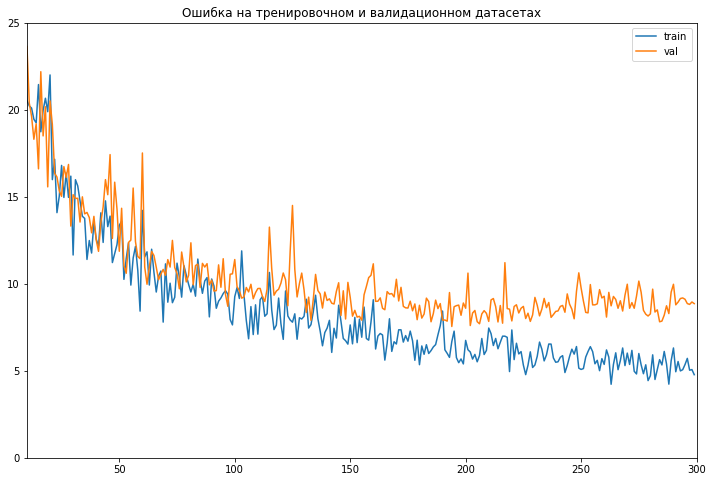

In [154]:
tf.random.set_seed(42)

lr = 3e-4

def eval_model(X_train, y_train, epoch, val_split=0.15):
  # if tf.config.experimental.list_physical_devices("GPU"):
      # with tf.device("GPU:0"): 
        h = model.fit(X_train, y_train, epochs=epoch, validation_split=0.15, 
                      batch_size=10, verbose=0)
        test_loss, test_r2 = model.evaluate(X_test, y_test, verbose=0)
        print(f'\tR2 на трейне - {h.history.get("r_square")[-1]:.6f};\n'
              f'\tR2 на валидационном сете - {h.history.get("val_r_square")[-1]:.6f};\n'
              f'\tR2 на тесте - {test_r2:6f}.')
        return h
        
# Добавим в модель дропаут слои, чтобы уменьшить переобучение

model = Sequential([Dense(256, activation='relu', input_shape=(13,)),
                    Dropout(0.2),
                    Dense(192, activation='relu'),
                    Dropout(0.2),
                    Dense(128, activation='linear'),
                    Dropout(0.2),
                    Dense(64, activation='relu'),
                    Dropout(0.1),
                    Dense(32, activation='linear'),
                    Dense(1, activation='relu')])

    
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))

h = eval_model(X_train, y_train, epoch=300)


plt.figure(figsize=(12, 8))
plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='val')
plt.xlim([10, 300])
plt.ylim([0, 25])
plt.title('Ошибка на тренировочном и валидационном датасетах')
plt.legend()
plt.show()

Разница между метрикой на трейне и тесте уменьшилась, но все равно осталась значительной, однако удалось сократить разницу между оценками для валидационного и тестового датасета и одновременно повысить метрику на тесте.


В результате донастройки модели удалось поднять метрику $R^2$ на тесте с __0.6259__ до __0.8905__. Среди прочего помогло увеличение слоев в сети, увеличение количества нейронов, количества эпох обучения и использование оптимайзера `SGD` с подобранным значением скорости обучения. Большой вклад в достижение этого результата внесло также изменение функции активации на некоторых слоях, прежде всего на входном и выходном, с линейной на _relu_.